In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import fiona
import os
import pickle
import googlemaps
import networkx as nx
import itertools

from collections import Counter
from datetime import datetime
from pprint import pprint
from mpl_toolkits.basemap import Basemap

from shapely.geometry import Point, shape, Polygon
from shapely.ops import unary_union

import shapely.speedups
shapely.speedups.enable()

if not os.path.exists(r'Data'):
    os.makedirs(r'Data')

if not os.path.exists(r"Data\temp"):
    os.makedirs(r'Data\temp')

# Generate QGIS code for visualization

## use updated file

In [2]:
# area_geoids.csv file path
file_dir = r'D:\Documents\20Fall\BH\Shapefiles-Tierra\\'
df = pd.read_csv(file_dir+r'destinations_in_region.csv')
df.head()

,GEOID,in_region
0,261476304004,0
1,261476316001,0
2,261635443002,0
3,261635452002,0
4,261635453001,0


In [3]:
df_t = df['GEOID'][df['in_region'] == 1].apply(
    lambda x: "\"GEOID\"" + "=" + "\'"+str(x)+"\'" + "OR")
df_t = df_t.dropna()
df_t.to_csv(file_dir + '\\area_geoids_transformed.csv')

In [4]:
df_t.head()

520    "GEOID"='260210003002'OR
521    "GEOID"='260210020003'OR
522    "GEOID"='260210017001'OR
524    "GEOID"='260210022003'OR
527    "GEOID"='260210020002'OR
Name: GEOID, dtype: object

# Import BH shapefile

In [5]:
with fiona.open(file_dir + r"Benton Harbor TAZs\BH_TAZ_2010.shp") as fc:
    pprint(fc.meta)
#     pprint(fc[0])

{'crs': {'ellps': 'GRS80', 'no_defs': True, 'proj': 'longlat'},
 'crs_wkt': 'GEOGCS["GCS_GRS_1980",DATUM["GRS_1980",SPHEROID["GRS_1980",6378137,298.2572221]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]]',
 'driver': 'ESRI Shapefile',
 'schema': {'geometry': 'Polygon',
            'properties': OrderedDict([('ID', 'int:10'),
                                       ('AREA', 'float:10.2'),
                                       ('BH_TAZ_NUM', 'int:8'),
                                       ('JURISDICTI', 'str:20'),
                                       ('POP_2010_T', 'int:12'),
                                       ('POP_2010_G', 'int:12'),
                                       ('HH_2010_TO', 'int:12'),
                                       ('HH_2010_OC', 'int:12'),
                                       ('TOTAL_AUTO', 'float:10.2'),
                                       ('CHILD_K12', 'float:10.2'),
                                       ('TOTAL_WORK', 'float:10.2'),
    

{'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True}


,ID,AREA,BH_TAZ_NUM,JURISDICTI,POP_2010_T,POP_2010_G,HH_2010_TO,HH_2010_OC,TOTAL_AUTO,CHILD_K12,...,SERVICE_20,OTHER_2010,AM_TRUCK,IDW_TRUCK,RETAIL_TRU,SERVICE_TR,OTHER_TRUC,SCHOOL_ENR,AREATYPE,geometry
0,137,0.39,137,Benton Charter Twp,13,0,7,6,4.10,0.33,...,0,0,0,0,0,0,0,0,5,"POLYGON ((-86.37252 42.07234, -86.38787 42.072..."
1,138,0.36,138,Benton Charter Twp,53,0,25,25,53.08,0.08,...,0,0,0,0,0,0,0,0,5,"POLYGON ((-86.37252 42.07234, -86.37252 42.073..."
2,139,0.25,139,Benton Charter Twp,27,0,24,15,28.10,0.07,...,10,2,0,2,2,10,0,0,3,"POLYGON ((-86.43647 42.06592, -86.43646 42.058..."
3,144,0.37,144,Benton Charter Twp,7,0,5,5,6.10,0.00,...,381,201,0,88,1211,381,122,0,2,"POLYGON ((-86.42779 42.07253, -86.42835 42.072..."
4,143,0.13,143,Benton Charter Twp,199,0,185,176,214.63,0.01,...,16,39,0,0,40,16,59,0,2,"POLYGON ((-86.42513 42.08305, -86.42513 42.082..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,38,0.03,38,Benton Harbor,206,0,76,62,49.40,1.74,...,16,2,0,0,5,16,2,0,2,"POLYGON ((-86.45150 42.11269, -86.45135 42.112..."
115,34,0.06,34,Benton Harbor,142,17,57,40,45.44,1.35,...,23,0,0,0,5,23,71,0,2,"POLYGON ((-86.44644 42.10765, -86.44761 42.108..."
116,30,0.02,30,Benton Harbor,0,0,0,0,0.00,0.00,...,181,21,0,0,2,181,21,0,2,"POLYGON ((-86.44163 42.10160, -86.44161 42.101..."
117,33,0.02,33,Benton Harbor,19,0,8,5,6.94,1.20,...,33,12,0,6,0,33,6,0,2,"POLYGON ((-86.44055 42.10160, -86.43879 42.101..."


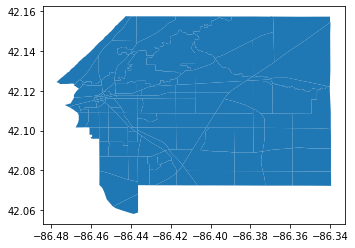

In [6]:
poly_BH = gpd.read_file(
    file_dir + r"Benton Harbor TAZs\BH_TAZ_2010.shp")

_ = poly_BH.plot()

print(poly_BH.crs)
poly_BH

In [7]:
poly_BH_summary = poly_BH.geometry.bounds
lolon, uplon, lolat, uplat = poly_BH_summary.minx.min(
), poly_BH_summary.maxx.max(), poly_BH_summary.miny.min(), poly_BH_summary.maxy.max()
print(lolon, uplon, lolat, uplat)

with open(r"Data\temp\boundary.p", "wb") as fp:
    pickle.dump([lolon, uplon, lolat, uplat], fp)

-86.477453 -86.339342 42.058115 42.157545


# Import outer BH area shapefile

In [8]:
poly_BH_outer = gpd.read_file(
    file_dir + r"Berrien Census Block Group Boundaries\tl_2019_26_bg.shp")
print(poly_BH_outer.crs)

{'init': 'epsg:4269'}


In [9]:
file_dir = r'D:\Documents\20Fall\BH\Shapefiles-Tierra\\'
df = pd.read_csv(file_dir+r'destinations_in_region.csv')
GEOID_outer = df.GEOID[df.in_region == 1]
GEOID_outer.values[0].dtype

dtype('int64')

In [10]:
idx = poly_BH_outer['GEOID'].apply(
    lambda x: True if np.int(x) in GEOID_outer.values else False)
poly_BH_outer = poly_BH_outer.loc[idx]

In [11]:
poly_BH_outer_summary = poly_BH_outer.geometry.bounds
lolon, uplon, lolat, uplat = poly_BH_outer_summary.minx.min(
), poly_BH_outer_summary.maxx.max(), poly_BH_outer_summary.miny.min(), poly_BH_outer_summary.maxy.max()
print(lolon, uplon, lolat, uplat)

-86.623997 -86.320005 41.899257999999996 42.24322


## Disgard outer zones which overlap with BH TAZs

In [12]:
BH_TAZ = Polygon()

whitelist = ['260210019001', '260210011001', '260210008002', '260210008001',
             '260210007003', '260210007001', '260210101001',
             '260210101004', '260210018001', '260210018002']

p = poly_BH.unary_union  # p is a geometry which is the union of BH TAZs

idx_delete = []
for index, row in poly_BH_outer.iterrows():
    if (row.geometry.intersects(p) or row.geometry.overlaps(p)) and row.GEOID not in whitelist:
        idx_delete.append(index)

poly_BH_outer = poly_BH_outer.drop(labels=idx_delete, axis=0)
poly_BH_outer.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
522,26,021,001700,1,260210017001,Block Group 1,G5030,S,3885199,3066,+42.0361694,-086.4800761,"POLYGON ((-86.48508 42.02959, -86.48507 42.032..."
532,26,021,001000,1,260210010001,Block Group 1,G5030,S,982485,121874,+42.0962199,-086.4770744,"POLYGON ((-86.48534 42.09367, -86.48477 42.093..."
557,26,021,011000,3,260210110003,Block Group 3,G5030,S,23282008,31005,+41.9117759,-086.4813652,"POLYGON ((-86.51398 41.94282, -86.50437 41.942..."
622,26,021,010100,2,260210101002,Block Group 2,G5030,S,5141500,1142559,+42.2365262,-086.3524139,"POLYGON ((-86.38785 42.22037, -86.38030 42.228..."
654,26,021,001100,2,260210011002,Block Group 2,G5030,S,3410951,3482,+42.0556473,-086.4808362,"POLYGON ((-86.49482 42.05185, -86.49482 42.051..."


## Find centroids of BH TAZs

In [13]:
# lolon, uplon, lolat, uplat = -86.63, -86.31, 41.89, 42.15
bm = Basemap(
    llcrnrlon=lolon,
    llcrnrlat=lolat,
    urcrnrlon=uplon,
    urcrnrlat=uplat,
    resolution="i",
    projection="tmerc",
    lat_0=42.07,
    lon_0=-86.45,
)

In [18]:
# copy poly to new GeoDataFrame
centroids_BH = poly_BH.copy()
# change the geometry to centroid of each polygon
centroids_BH.geometry = centroids_BH['geometry'].centroid
# same crs
centroids_BH.crs = poly_BH.crs
centroids_BH.rename(columns={"ID": "GEOID"}, inplace=True)
centroids_BH.head()

,GEOID,AREA,BH_TAZ_NUM,JURISDICTI,POP_2010_T,POP_2010_G,HH_2010_TO,HH_2010_OC,TOTAL_AUTO,CHILD_K12,...,SERVICE_20,OTHER_2010,AM_TRUCK,IDW_TRUCK,RETAIL_TRU,SERVICE_TR,OTHER_TRUC,SCHOOL_ENR,AREATYPE,geometry
0,137,0.39,137,Benton Charter Twp,13,0,7,6,4.10,0.33,...,0,0,0,0,0,0,0,0,5,POINT (-86.38041 42.07597)
1,138,0.36,138,Benton Charter Twp,53,0,25,25,53.08,0.08,...,0,0,0,0,0,0,0,0,5,POINT (-86.36588 42.07601)
2,139,0.25,139,Benton Charter Twp,27,0,24,15,28.10,0.07,...,10,2,0,2,2,10,0,0,3,POINT (-86.44089 42.06247)
3,144,0.37,144,Benton Charter Twp,7,0,5,5,6.10,0.00,...,381,201,0,88,1211,381,122,0,2,POINT (-86.42428 42.07855)
4,143,0.13,143,Benton Charter Twp,199,0,185,176,214.63,0.01,...,16,39,0,0,40,16,59,0,2,POINT (-86.42873 42.08387)


## Find centroids of BH outer zones

In [19]:
# copy poly to new GeoDataFrame
centroids_BH_outer = poly_BH_outer.copy()
# change the geometry to centroid of each polygon
centroids_BH_outer.geometry = centroids_BH_outer['geometry'].centroid
# same crs
centroids_BH_outer.crs = poly_BH_outer.crs
centroids_BH_outer.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
522,26,021,001700,1,260210017001,Block Group 1,G5030,S,3885199,3066,+42.0361694,-086.4800761,POINT (-86.47533 42.03988)
532,26,021,001000,1,260210010001,Block Group 1,G5030,S,982485,121874,+42.0962199,-086.4770744,POINT (-86.47693 42.09581)
557,26,021,011000,3,260210110003,Block Group 3,G5030,S,23282008,31005,+41.9117759,-086.4813652,POINT (-86.48481 41.92109)
622,26,021,010100,2,260210101002,Block Group 2,G5030,S,5141500,1142559,+42.2365262,-086.3524139,POINT (-86.36317 42.23192)
654,26,021,001100,2,260210011002,Block Group 2,G5030,S,3410951,3482,+42.0556473,-086.4808362,POINT (-86.47931 42.05666)


In [29]:
poly_BH.rename(columns={"ID": "GEOID"}, inplace=True)
poly_BH.head(1)

,GEOID,AREA,BH_TAZ_NUM,JURISDICTI,POP_2010_T,POP_2010_G,HH_2010_TO,HH_2010_OC,TOTAL_AUTO,CHILD_K12,...,SERVICE_20,OTHER_2010,AM_TRUCK,IDW_TRUCK,RETAIL_TRU,SERVICE_TR,OTHER_TRUC,SCHOOL_ENR,AREATYPE,geometry
0,137,0.39,137,Benton Charter Twp,13,0,7,6,4.1,0.33,...,0,0,0,0,0,0,0,0,5,"POLYGON ((-86.37252 42.07234, -86.38787 42.072..."


In [36]:
# combine two polygon serieses
poly_series = poly_BH[["geometry", "GEOID"]].append(
    poly_BH_outer[["geometry", "GEOID"]], ignore_index=True)
# copy poly series to new GeoDataFrame
centroid_series = poly_series.copy()
# change the geometry to centroid of each polygon
centroid_series = centroid_series.centroid
# same crs
centroid_series.crs = poly_series.crs

fig = plt.figure(figsize=(60, 60))
ax = fig.gca()

_ = poly_series.boundary.plot(ax=ax, color='blue')
_ = centroid_series.plot(ax=ax, marker=".", color="black")

for i, (xx, yy) in enumerate(zip(centroid_series.x, centroid_series.y), start=0):
    plt.annotate(str(i), (xx, yy), xytext=(5, 5), textcoords='offset points')

# Uncomment to save the figure
# fig.savefig(r"Data\zones_number.png",  bbox_inches="tight", dpi=500)
plt.close()

## Zone ID Shapefile and ID Converter

In [49]:
gdf = gpd.GeoDataFrame(poly_series, crs=poly_series.crs)
gdf["centroid"] = centroid_series.apply(lambda x: str((x.x, x.y)))
gdf["Zone ID"] = gdf.index.values

try:
    gdf.to_file(r"Data\shapefile\zone_id.shp")
except:
    os.makedirs(r"Data\shapefile")
    gdf.to_file(r"Data\shapefile\zone_id.shp")
    
id_converter = {i: int(j) for (i, j) in gdf["GEOID"].items()}
with open(r"Data\id_converter.p", "wb") as fp:
    pickle.dump(id_converter, fp)    
gdf.head()

,geometry,GEOID,centroid,Zone ID
0,"POLYGON ((-86.37252 42.07234, -86.38787 42.072...",137,"(-86.38040952841658, 42.07597029404763)",0
1,"POLYGON ((-86.37252 42.07234, -86.37252 42.073...",138,"(-86.3658842157999, 42.076010205991466)",1
2,"POLYGON ((-86.43647 42.06592, -86.43646 42.058...",139,"(-86.44089145868426, 42.062470402047644)",2
3,"POLYGON ((-86.42779 42.07253, -86.42835 42.072...",144,"(-86.42428287005157, 42.078551690738124)",3
4,"POLYGON ((-86.42513 42.08305, -86.42513 42.082...",143,"(-86.42873377290401, 42.08387216624637)",4


In [40]:
df = pd.DataFrame(columns=["lon", "lat"])
df.index.name = "zone id"
df["lon"], df["lat"] = centroid_series.x, centroid_series.y
df.to_csv(r"Data\zone_id.csv")

## Generate station data and neighbor station

In [19]:
# get utm coordinates for the centroids
c_lon, c_lat = bm(centroid_series.x, centroid_series.y, inverse=False)
# reverse lat lon order used for googlemaps API
lat_lon = np.c_[c_lat, c_lon]
station = dict()
for i, center in enumerate(centroid_series):
    station[i] = dict()
    station[i]["lat_lon"] = [
        centroid_series.iloc[i].y, centroid_series.iloc[i].x]
    station[i]["utm"] = lat_lon[i]
    neighbors = np.arange(len(poly_series))[~poly_series.disjoint(
        poly_series[i])]
    # exclude self node in neighbours
    station[i]["neighbours"] = [n for n in neighbors if n != i]

pickle.dump(station, open(r"Data\temp\Station.p", "wb"))

In [20]:
import itertools

pprint(dict(itertools.islice(station.items(), 3)))

{0: {'lat_lon': [42.07597029404763, -86.38040952841658],
     'neighbours': [1, 9, 68, 69, 70, 137],
     'utm': array([19615.67474128, 20197.26260538])},
 1: {'lat_lon': [42.076010205991466, -86.3658842157999],
     'neighbours': [0, 10, 49, 69, 70, 137],
     'utm': array([19621.18837363, 21399.25908595])},
 2: {'lat_lon': [42.062470402047644, -86.44089145868426],
     'neighbours': [23, 134, 135, 137, 162],
     'utm': array([18113.87584868, 15192.41291105])}}


### Use your google map API key here

In [21]:
# your google map API key
gmap_key = ""

In [23]:
station = pickle.load(open(r"Data\temp\Station.p", "rb"))
num_station = len(station)
gmaps = googlemaps.Client(key=gmap_key)
# datetime needs to be no later than current time, format: Y,M,D,h,m,s
currenttime = datetime(2021, 2, 1, 12, 0, 0)

# construct graphs of travel time and travel distance
G_d = nx.Graph()
G_t = nx.Graph()
G_d.add_nodes_from(np.arange(num_station))
G_t.add_nodes_from(np.arange(num_station))

for i in range(num_station):
    for j in station[i]["neighbours"]:
        if i < j:
            direction_result = gmaps.directions(
                tuple(station[i]["lat_lon"]),
                tuple(station[j]["lat_lon"]),
                mode="driving",
                avoid="ferries",
                departure_time=currenttime,
            )

            w_t = np.round(
                direction_result[0]["legs"][0]["duration"][u"value"] / 60.0, decimals=2
            )
            w_d = np.round(
                direction_result[0]["legs"][0]["distance"][u"value"] *
                0.000621371,
                decimals=2,
            )

            G_t.add_edge(i, j, weight=w_t)
            G_d.add_edge(i, j, weight=w_d)

pickle.dump(G_t, open(r"Data\temp\G_t.p", "wb"))
pickle.dump(G_d, open(r"Data\temp\G_d.p", "wb"))

In [26]:
GraphWeights_t = [(u, v, w["weight"]) for (u, v, w) in G_t.edges(data=True)]
name = ["origin", "destination", "travel time(min)"]
df_t = pd.DataFrame(data=GraphWeights_t, columns=name)

GraphWeights_d = [(u, v, w["weight"]) for (u, v, w) in G_d.edges(data=True)]
name_d = ["origin", "destination", "travel distance(km)"]
df_d = pd.DataFrame(data=GraphWeights_d, columns=name_d)

df = df_t.merge(df_d, how='outer', on=["origin", "destination"])

try:
    df.to_csv(r"Data\census\station_distance.csv", sep=",")
except FileNotFoundError:
    if not os.path.exists('Data\census'):
        os.makedirs('Data\census')
    df.to_csv(r"Data\census\station_distance.csv", sep=",")

## Pivoting distance table to a matrix form

In [35]:
df_distance = pd.read_csv(r"Data\census\station_distance.csv", index_col=[0])
df_distance_mtx = pd.pivot_table(
    df_distance, index='origin', columns='destination')

df_distance_mtx.to_csv(r"Data\census\station_distance_mtx.csv", sep=",")

In [48]:
df_distance_mtx["travel distance(km)"][145][139]

2.37

# Load PCTrans 2019 trip data

## Load trip orgins

In [34]:
ps_taca = ["onX", "onY", "Counts"]
df_taca = pd.read_csv(r"PCTrans\Oneday.csv", parse_dates=ps_taca, sep=",")
df_taca.rename(columns={"onX": "lon", "onY": "lat",
                        "Counts": "counts"}, inplace=True)
df_taca.dropna()
df_taca = df_taca[["lon", "lat", "counts"]]
pickle.dump(df_taca, open(r"Data\temp\PCTrans Data on.p", "wb"))
# df_taca.to_hdf(r"Data\census\PCTrans Data.h5", key="df_taca", mode="w")

In [35]:
df_taca = pickle.load(open(r"Data\temp\PCTrans Data on.p", "rb"))
lolon, uplon, lolat, uplat = pickle.load(open(r"Data\temp\boundary.p", "rb"))
N_trips = len(df_taca)
bm = Basemap(
    llcrnrlon=lolon,
    llcrnrlat=lolat,
    urcrnrlon=uplon,
    urcrnrlat=uplat,
    resolution=None,
    projection="tmerc",
    lat_0=42.07,
    lon_0=-86.45,
)
df_taca["utm_lon"], df_taca["utm_lat"] = bm(
    df_taca.lon.values, df_taca.lat.values)
pickle.dump(df_taca, open(r"Data\temp\PCTrans Data on2.p", "wb"))

## Load trip destinations

In [38]:
ps_taca = ["offX", "offY", "Counts"]
df_taca = pd.read_csv(r"PCTrans\Oneday.csv", parse_dates=ps_taca, sep=",")
df_taca.rename(columns={"offX": "lon", "offY": "lat", "Counts": "counts"}, inplace=True)
df_taca.dropna()
df_taca = df_taca[["lon", "lat", "counts"]]
pickle.dump(df_taca, open(r"Data\temp\PCTrans Data off.p", "wb"))

In [39]:
df_taca = pickle.load(open(r"Data\temp\PCTrans Data off.p", "rb"))
lolon, uplon, lolat, uplat = pickle.load(open(r"Data\temp\boundary.p", "rb"))
N_trips = len(df_taca)
bm = Basemap(
    llcrnrlon=lolon,
    llcrnrlat=lolat,
    urcrnrlon=uplon,
    urcrnrlat=uplat,
    resolution=None,
    projection="tmerc",
    lat_0=42.07,
    lon_0=-86.45,
)
df_taca["utm_lon"], df_taca["utm_lat"] = bm(
    df_taca.lon.values, df_taca.lat.values)
pickle.dump(df_taca, open(r"Data\temp\PCTrans Data off2.p", "wb"))

In [79]:
def locate_point(point, geoseries):
    """
    Checker function which determines if a coordinate is within 
    the geoseries and return the zone id where the point is 
    located
    """
    idx_list = geoseries.index[geoseries.geometry.contains(point)].tolist()
    return idx_list[0] if len(idx_list)>=1 else np.nan

In [114]:
df_employ = pd.read_csv(r"Data\census\new employment data.txt",
                        sep=" ", header=None, names=["utm_lon", "utm_lat", "count"])
df_taca_on = pickle.load(open(r"Data\temp\PCTrans Data on2.p", "rb"))
df_taca_off = pickle.load(open(r"Data\temp\PCTrans Data off2.p", "rb"))
zone_id = gpd.read_file(r"Data\shapefile\zone_id.shp")

on_id = [locate_point(Point(p), zone_id.geometry) for p in zip(
    df_taca_on.lon.astype(float), df_taca_on.lat.astype(float))]
off_id = [locate_point(Point(p), zone_id.geometry) for p in zip(
    df_taca_off.lon.astype(float), df_taca_off.lat.astype(float))]
pickle.dump([on_id, off_id], open(r"Data\temp\PCTrans Data OD.p", "wb"))

In [145]:
on_id, off_id = pickle.load(open(r"Data\temp\PCTrans Data OD.p", "rb"))
df_od = pd.DataFrame(list(zip(on_id, off_id)), columns=[
                     "on_id", "off_id"]).dropna().astype(int)
df_od["od"] = list(zip(df_od.on_id, df_od.off_id))
df_od.index.name = "trip_id"
df_od.to_csv(r"Data\pctrans_trip_od.csv")
df_od.head()

dict_on, dict_off, dict_od = Counter(df_od.on_id.values), Counter(
    df_od.off_id.values), Counter(df_od.od)
pickle.dump([dict_on, dict_off, dict_od], open(r"Data\temp\trip_stats.p", "wb"))

## Plot depth color of trip orgin

In [163]:
zone_id = gpd.read_file(r"Data\shapefile\zone_id.shp")
dict_on, dict_off, dict_od = pickle.load(open(r"Data\temp\trip_stats.p", "rb"))
zone_id.index.name="zone_id"
df_on_count = pd.DataFrame.from_dict(dict_on, orient='index', columns=["on_count"])
df_on_count.index.name = "zone_id"
df_off_count = pd.DataFrame.from_dict(dict_off, orient='index', columns=["off_count"])
df_off_count.index.name = "zone_id"

In [189]:
zone_id_count = zone_id.merge(df_on_count, on="zone_id", how="left")
zone_id_count = zone_id_count.merge(df_off_count, on="zone_id", how="left")
zone_id_count[["on_count", "off_count"]
              ] = zone_id_count[["on_count", "off_count"]].fillna(0)
zone_id_count.to_csv(r'Data\trip_count.csv')

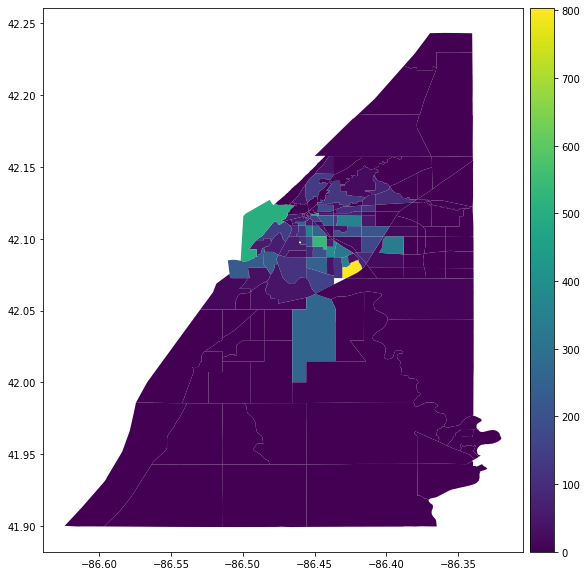

In [181]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
_ = zone_id_count.plot(column="on_count", ax=ax, legend=True, cax=cax)

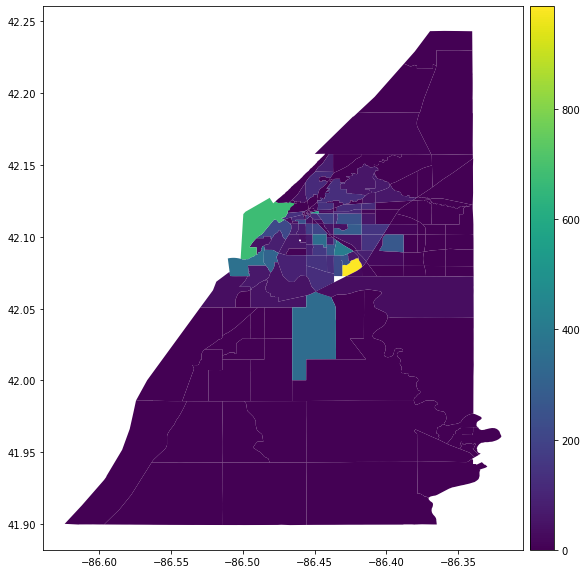

In [179]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
_ = zone_id_count.plot(column="off_count", ax=ax, legend=True, cax=cax)

In [187]:
zone_id_count.on_count.nlargest(5)

zone_id
3      803.0
15     537.0
150    507.0
104    457.0
17     401.0
Name: on_count, dtype: float64

In [188]:
zone_id_count.off_count.nlargest(5)

zone_id
3      986.0
150    676.0
104    564.0
73     413.0
159    364.0
Name: off_count, dtype: float64

## Zone aggregation

### Aggregation list

In [82]:
l1 = [151, 152, 153, 158]
l2 = [31, 37, 36, 113, 108, 107, 103, 104, 110, 109, 43, 44, 111, 112, 11, 98]
l3 = []
l4 = [99, 100, 101]
l5 = [105, 102, 114, 106]
l6 = [115, 118]
l7 = [116, 117, 16]
l8 = [32, 39, 38, 40, 45, 29]
l9 = [26, 27, 28]
l10 = [33, 97]
l11 = [59, 63]
l12 = [4, 5, 6, 3, 7, 8]
l13 = [60, 47, 64, 48, 69, 49, 1, 10]
l14 = [58, 62, 61, 67, 66, 65, 68, 70, 9, 0]
l15 = []
l16 = [41, 42, 12]
l17 = [140, 141, 20]
l18 = [14, 15, 19, 18, 17]
l19 = [92, 90, 91, 84, 81]
l20 = [72, 73, 75]
l21 = [82, 83]
l22 = [78, 79]
l23 = [46, 53]
l24 = [87, 88]

agg_list = [l1, l2, l3, l4, l5, l6, l7, l8, l9,
            l10, l11, l12, l13, l14, l15, l16, l17, l18, l19,
           l20, l21, l22, l23, l24]
agg_list = [lst for lst in agg_list if lst != []]

### Checker function, make sure there is no common value in any pair of lists

In [88]:
for pair in itertools.product(agg_list, repeat=2):
    if pair[0] != pair[1] and list(set.intersection(*map(set, pair))) != []:
        print("not disjoint list, intersection",
              list(set.intersection(*map(set, pair))), pair)

In [87]:
zone_id = gpd.read_file(r"Data\shapefile\zone_id.shp")
zone_id['group'] = zone_id['Zone ID']

for lst in agg_list:
    zone_id['group'].replace(lst, min(lst), inplace=True)

zone_agg = zone_id.dissolve(by='group')
zone_agg.to_csv(r"Data\zone_id_agg.csv")
zone_agg

,geometry,centroid,Zone ID
group,,,
0,"POLYGON ((-86.37252 42.07234, -86.38787 42.072...","(-86.38040952841658, 42.07597029404763)",0
1,"POLYGON ((-86.33943 42.07947, -86.33934 42.072...","(-86.3658842157999, 42.076010205991466)",1
2,"POLYGON ((-86.43647 42.06592, -86.43646 42.058...","(-86.44089145868426, 42.062470402047644)",2
3,"POLYGON ((-86.42660 42.07246, -86.42779 42.072...","(-86.42428287005157, 42.078551690738124)",3
11,"POLYGON ((-86.45540 42.10896, -86.45616 42.108...","(-86.45367530238144, 42.1111173236876)",11
...,...,...,...
160,"POLYGON ((-86.50250 42.06509, -86.50220 42.065...","(-86.49059878951579, 42.07268533219162)",160
161,"POLYGON ((-86.48545 42.08231, -86.48544 42.083...","(-86.48083415027868, 42.08443033531176)",161
162,"POLYGON ((-86.48442 42.06518, -86.48434 42.065...","(-86.46896145296067, 42.06576230845876)",162


In [85]:
try:
    zone_agg.to_file(r"Data\shapefile\zone_id_agg.shp")
except:
    os.makedirs(r"Data\shapefile")
    zone_agg.to_file(r"Data\shapefile\zone_id_agg.shp")

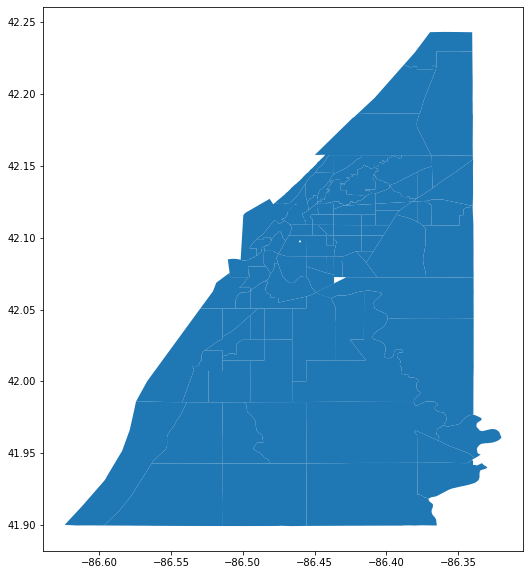

In [86]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
_ = zone_agg.plot(ax=ax)